In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess
import json

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [5]:
df = pd.read_csv('./data/dataset_uralic.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
574,jaan su paris jaan su paris jaan su paris jaan,Estonian
4267,kasakkoja kohdeltiin kasakkoja kohdeltiin,Finnish
4,margus onnelikus arewuses margus onnelikus,Estonian
2244,vissza az ujonnan vissza az ujonnan vissza az,Hungarian
2982,egeszsegtelen es a egeszsegtelen es a,Hungarian


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [6]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Input dimension: 48
Rows: 4785
Amount of languages to identify: 3


In [7]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(8, activation='relu')
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=2048,verbose=1)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.3278 - loss: 1.7166 - val_accuracy: 0.3323 - val_loss: 1.6117
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3333 - loss: 1.7735 - val_accuracy: 0.3438 - val_loss: 1.1905
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.3433 - loss: 1.1897 - val_accuracy: 0.3239 - val_loss: 1.2044
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3433 - loss: 1.1886 - val_accuracy: 0.3386 - val_loss: 1.1522
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3449 - loss: 1.1482 - val_accuracy: 0.3323 - val_loss: 1.1174
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3369 - loss: 1.1172 - val_accuracy: 0.3511 - val_loss: 1.0969
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3537 - loss: 1.1032 - val_accuracy: 0.3908 - val_loss: 1.0915
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.3670 - loss: 1.0952 - val_accuracy: 0.3480 - v

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

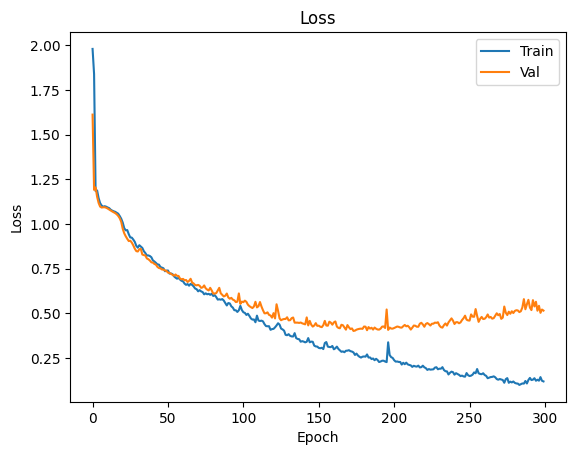

In [9]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

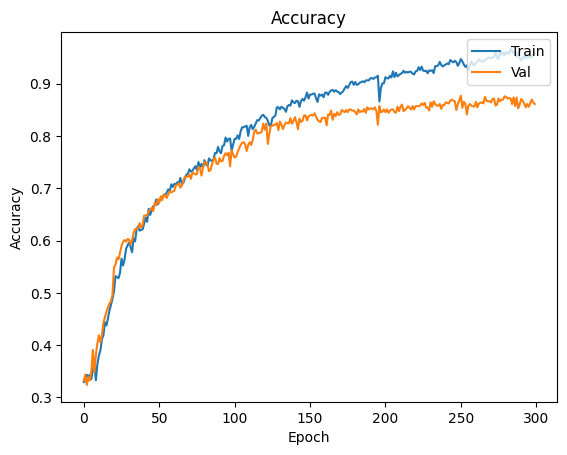

In [10]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [14]:
prediction_word = "hej"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: hej
Text after preprocessing: hej hej hej hej hej
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Language_Estonian: 0.0
Language_Finnish: 65.6
Language_Hungarian: 34.4


# Save model
Here a model can be loaded

In [12]:
model.save('./models/model_uralic.keras')

# Load model
Here a model can be loaded

In [13]:
model = load_model('./models/model_uralic.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_uralic.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))